<a href="https://colab.research.google.com/github/adakar2000/UczenieMaszynowe/blob/UseCase2/Case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Przegląd danych:

- Podaj liczbę filmów Sci-Fi
- Pokaż rozkład ocen komedii
- Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej ocenianych
2. System rekomendacyjny

- Zbuduj system na podstawie algorytmu SVD oraz kNNwithMeans
- Czym różni się algorytm kNN with means od standardowego kNN?
-Wykorzystaj metodę hiperparametryzacji GridSearch do wyboru liczby sąsiadów od 2-6
- W ocenie metod wykorzystaj walidację krzyżową
3. Podaj rekomendacje po obejrzeniu filmu: Jumanji  oraz Flint

In [3]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162994 sha256=4725fe05a443cab2057b7e9e04f286b35148e86169b628f59b3fcfe4b4c77e61
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.model_selection import train_test_split


In [23]:
ratings_data = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies_data = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [6]:
movies_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [7]:
ratings_data

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


1. Przegląd danych

In [8]:
# Podaj liczbę filmów Sci-Fi
sci_fi_count = movies_data[movies_data['genres'].str.contains('Sci-Fi')].shape[0]
print("Liczba filmów Sci-Fi:", sci_fi_count)

Liczba filmów Sci-Fi: 980


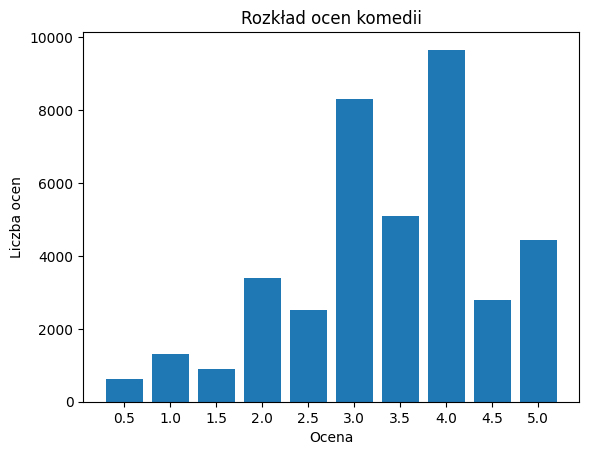

In [9]:
# Pokaż rozkład ocen komedii
comedy_ratings = ratings_data[ratings_data['movieId'].isin(movies_data[movies_data['genres'].str.contains('Comedy')]['movieId'])]['rating']
comedy_ratings_distribution = comedy_ratings.value_counts().sort_index()

plt.bar(comedy_ratings_distribution.index, comedy_ratings_distribution.values, width=0.4)
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.title('Rozkład ocen komedii')
plt.xticks(comedy_ratings_distribution.index)
plt.show()

In [10]:
# Podaj średnią ocen wszystkich filmów akcji
action_movies = movies_data[movies_data['genres'].str.contains('Action')]
action_ratings = ratings_data[ratings_data['movieId'].isin(action_movies['movieId'])]
action_mean_rating = action_ratings['rating'].mean()
print("Średnia ocen wszystkich filmów akcji:", action_mean_rating)

Średnia ocen wszystkich filmów akcji: 3.447984331646809


In [44]:
# Średnia ocen 3 filmów akcji najwyżej ocenianych
movie_ratings = ratings_data.merge(movies_data[movies_data['genres'].str.contains('Action')], on='movieId')
rating_akcji = movie_ratings['rating'].mean()

# Teraz obliczamy średnią ocen dla każdego filmu akcji oraz liczbę głosów
srednia = movie_ratings.groupby('title').agg({'rating': ['mean', 'count']}).reset_index()

# df
srednia.columns = ['title', 'mean_rating', 'count_rating']

# Sortujemy filmy akcji według średniej oceny, ale tylko te z liczbą głosów wyższą od ustalonego progu

sortowanie1 = srednia[srednia['count_rating'] >= 17]
sortowanie2 = srednia[srednia['count_rating'] >= 150]

# Wybieramy trzy filmy akcji z najwyższą średnią oceną
top3_sort1 = sortowanie1.sort_values(by='mean_rating', ascending=False).head(3)
top3_sort2 = sortowanie2.sort_values(by='mean_rating', ascending=False).head(3)

print(f"Według metody gdzie filmy mają conajmniej 17 głosów to te są trzema najwyżej ocenianymi:\n{top3_sort1}")
print(f"Według metody gdzie filmy mają conajmniej 150 głosów to te są trzema najwyżej ocenianymi:\n{top3_sort2}")

Według metody gdzie filmy mają conajmniej 17 głosów to te są trzema najwyżej ocenianymi:
                                                  title  mean_rating  \
1173  Once Upon a Time in the West (C'era una volta ...     4.305556   
972                                        Logan (2017)     4.280000   
551                                   Fight Club (1999)     4.272936   

      count_rating  
1173            18  
972             25  
551            218  
Według metody gdzie filmy mają conajmniej 150 głosów to te są trzema najwyżej ocenianymi:
                                                  title  mean_rating  \
551                                   Fight Club (1999)     4.272936   
1505          Star Wars: Episode IV - A New Hope (1977)     4.231076   
1506  Star Wars: Episode V - The Empire Strikes Back...     4.215640   

      count_rating  
551            218  
1505           251  
1506           211  


2. System rekomendacyjny

In [15]:
# Konwersja danych do formatu, który może być użyty przez bibliotekę Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

In [16]:
# Budowa systemu rekomendacyjnego opartego na algorytmie SVD
svd_model = SVD()
cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8674  0.8798  0.8692  0.8776  0.8783  0.8745  0.0051  
MAE (testset)     0.6665  0.6780  0.6673  0.6746  0.6721  0.6717  0.0043  
Fit time          2.07    1.69    1.71    1.59    1.72    1.76    0.16    
Test time         0.43    0.22    0.37    0.14    0.26    0.28    0.11    


{'test_rmse': array([0.86739442, 0.87979358, 0.86924387, 0.87759319, 0.87827413]),
 'test_mae': array([0.66650018, 0.67798081, 0.66727769, 0.67456752, 0.67212058]),
 'fit_time': (2.0703251361846924,
  1.6921160221099854,
  1.7098584175109863,
  1.5878567695617676,
  1.7211434841156006),
 'test_time': (0.43146443367004395,
  0.21938085556030273,
  0.37017154693603516,
  0.13887262344360352,
  0.2562744617462158)}

In [17]:
# Budowa systemu rekomendacyjnego opartego na algorytmie kNN with Means
knn_model = KNNWithMeans()
cross_validate(knn_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9034  0.8976  0.8992  0.8927  0.8932  0.8972  0.0040  
MAE (testset)     0.6882  0.6852  0.6867  0.6805  0.6846  0.6850  0.0026  
Fit time          0.15    0.19    0.27    0.22    0.19    0.20    0.04    
Test time         1.52    2.05    2.36    2.42    1.51    1.97    0.39    


{'test_rmse': array([0.90339684, 0.89755303, 0.89915511, 0.89274755, 0.89317326]),
 'test_mae': array([0.68823025, 0.68523612, 0.68671896, 0.6804747 , 0.6845589 ]),
 'fit_time': (0.14865779876708984,
  0.18537473678588867,
  0.2663586139678955,
  0.22156310081481934,
  0.1920609474182129),
 'test_time': (1.5229179859161377,
  2.05098032951355,
  2.355752468109131,
  2.4206554889678955,
  1.5069940090179443)}

# Różnice między kNN with Means a standardowym kNN:
kNN with Means uwzględnia średnią ocen użytkowników jako korektę dla ocen, co może poprawić dokładność rekomendacji.

In [19]:
# Wykorzystanie GridSearchCV do wyboru liczby sąsiadów od 2-6 dla kNN with Means
param_grid = {'k': [2, 3, 4, 5, 6]}
grid_search = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search.fit(data)
print("Najlepsze parametry dla kNN with Means:", grid_search.best_params)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

3. Podaj rekomendacje po obejrzeniu filmu: Jumanji  oraz Flint

In [35]:
# Przygotowanie danych i modelu
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
model = KNNWithMeans()
model.fit(trainset)

# Tworzymy funkcje znajdującą podobne filmy
def get_similar_movies(movie_title, k=10):
  movie_id = movies_data[movies_data['title'].str.contains(movie_title)].iloc[0]['movieId']
  neighbors = model.get_neighbors(movie_id, k=k)
  neighbor_movies = movies_data[movies_data['movieId'].isin(neighbors)]
  return neighbor_movies

# Sprawdzamy rekomendacje po obejrzeniu Jumanji i Flint
similar_to_jumanji = get_similar_movies('Jumanji')
similar_to_flint = get_similar_movies('Flint')

print("Filmy podobne do 'Jumanji':\n", similar_to_jumanji)
print("Filmy podobne do 'Flint':\n", similar_to_flint)

Computing the msd similarity matrix...
Done computing similarity matrix.
Filmy podobne do 'Jumanji':
      movieId                                   title                genres
49        54                   Big Green, The (1995)       Children|Comedy
66        74                     Bed of Roses (1996)         Drama|Romance
114      137                  Man of the Year (1995)           Documentary
177      209               White Man's Burden (1995)                 Drama
262      302  Queen Margot (Reine Margot, La) (1994)         Drama|Romance
301      343           Baby-Sitters Club, The (1995)              Children
383      440                             Dave (1993)        Comedy|Romance
384      441               Dazed and Confused (1993)                Comedy
397      456                            Fresh (1994)  Crime|Drama|Thriller
Filmy podobne do 'Flint':
      movieId                                              title  \
44        48                                  Pocahont